In [1]:
import os
import glob
import json
import yaml
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:.3f}'.format

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import Orange
import baycomp

import sys
sys.path.append('..')

import seq2tens

plots_dir = './plots/'
if not os.path.isdir(plots_dir):
    os.mkdir(plots_dir)

2023-08-10 21:40:19.560115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-10 21:40:19.560150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Get list of datasets

In [2]:
datasets = sorted(seq2tens.datasets.get_available_datasets(), key=lambda x: str(x).lower())

#### Load external baselines

In [3]:
with open('./configs/ext_baselines.yaml', 'r') as f:
    results_ext = yaml.load(f, Loader=yaml.SafeLoader)

for method_name in results_ext:
    for ds_name in datasets:
        if ds_name not in results_ext[method_name]:
            results_ext[method_name][ds_name] = float('nan')
            print(f'Warning | Missing external baseline result for {method_name}:{ds_name}')

#### Parse experiment results

In [4]:
# load list of experiment configs
with open('./configs/configs.yaml', 'r') as f:
    configs = yaml.load(f, Loader=yaml.SafeLoader)

# parse results
results = {cfg_name : {ds_name : [] for ds_name in datasets} for cfg_name in configs}
exp_ps = [p for p in glob.glob('./benchmarks/*') if os.path.basename(p) != '_sources']
for i, path in enumerate(exp_ps):
    exp_num = os.path.basename(path)
    config_fp = os.path.join(path, 'config.json')
    with open(config_fp, 'r') as f:
        config = json.load(f)
    cfg_name = config['config_name']
    ds_name = config['dataset']['dataset_name']
    mets_fp = os.path.join(path, 'metrics.json')
    
    interrupted = False
    if os.path.exists(mets_fp):
        with open(mets_fp, 'r') as f:
            mets = json.load(f)
    else:
        interrupted = True

    if interrupted or 'testing.final_accuracy' not in mets:
        print(f'Warning | Experiment #{exp_num} ({cfg_name}:{ds_name}) is still running or has been interrupted.')
    else:
        results[cfg_name][ds_name].append(mets['testing.final_accuracy']['values'][0])

In [5]:
# check number of available results per config+dataset
for cfg_name in configs:
    for ds_name in datasets:
        if len(results[cfg_name][ds_name]) < 5:
            print(f'Warning | Only ({len(results[cfg_name][ds_name])}/{5}) results are available for {cfg_name}:{ds_name}')
        else:
            print(f'Success | All ({len(results[cfg_name][ds_name])}/{5}) results are available for {cfg_name}:{ds_name}')

Success | All (5/5) results are available for DeepLS2T64:ArabicDigits
Success | All (5/5) results are available for DeepLS2T64:AUSLAN
Success | All (5/5) results are available for DeepLS2T64:CharacterTrajectories
Success | All (5/5) results are available for DeepLS2T64:CMUsubject16
Success | All (5/5) results are available for DeepLS2T64:DigitShapes
Success | All (5/5) results are available for DeepLS2T64:ECG
Success | All (5/5) results are available for DeepLS2T64:JapaneseVowels
Success | All (5/5) results are available for DeepLS2T64:KickvsPunch
Success | All (5/5) results are available for DeepLS2T64:LIBRAS
Success | All (5/5) results are available for DeepLS2T64:NetFlow
Success | All (5/5) results are available for DeepLS2T64:PEMS
Success | All (5/5) results are available for DeepLS2T64:PenDigits
Success | All (5/5) results are available for DeepLS2T64:Shapes
Success | All (5/5) results are available for DeepLS2T64:UWave
Success | All (5/5) results are available for DeepLS2T64:Wafe

#### Organize results

In [6]:
cfg_names_ext = list(results_ext.keys())
cfg_names_base = [k for k in configs if 'LS2T' not in k]
cfg_names_main = [k for k in configs if 'LS2T' in k]

In [7]:
results_mean = {cfg_name : {ds_name : np.round(np.mean(results[cfg_name][ds_name]), 3) if len(results[cfg_name][ds_name]) > 0 else float('nan') for ds_name in datasets} for cfg_name in results}
results_std = {cfg_name : {ds_name : np.round(np.std(results[cfg_name][ds_name]), 3) if len(results[cfg_name][ds_name]) > 0 else float('nan') for ds_name in datasets} for cfg_name in results}

results_str = {cfg_name : {ds_name : f'{results_mean[cfg_name][ds_name]:.3f}({results_std[cfg_name][ds_name]:.3f})' if len(results[cfg_name][ds_name]) > 0 else float('nan') for ds_name in datasets} for cfg_name in results}

results_base = {k : v for k, v in results_mean.items() if k in cfg_names_base}
results_main = {k : v for k, v in results_mean.items() if k in cfg_names_main}

results_all = {**results_ext, **results_base, **results_main}
results_all = {cfg_name : {ds_name : results_all[cfg_name][ds_name] for ds_name in datasets} for cfg_name in results_all}

results_base_str = {k : v for k, v in results_str.items() if k in cfg_names_base}
results_main_str = {k : v for k, v in results_str.items() if k in cfg_names_main}

results_all_str = {**results_ext, **results_base_str, **results_main_str}
results_all_str = {cfg_name : {ds_name : results_all_str[cfg_name][ds_name] for ds_name in datasets} for cfg_name in results_all_str}

#### Visualize as dataframe

In [8]:
idx = {i : ds_name for i, ds_name in enumerate(datasets)}

idx[len(datasets)] = 'Avg.acc.'
idx[len(datasets)+1] = 'Med.acc.'
idx[len(datasets)+2] = 'Sd.acc.'
idx[len(datasets)+3] = 'Avg.rank'
idx[len(datasets)+4] = 'Med.rank'
idx[len(datasets)+5] = 'Sd.rank'

df = pd.DataFrame.from_dict(results_all) # .rename(index=idx)
# display(df)

results_array = df.values

best = df.index[np.argmax(df.values, axis=1)]

ranks = df.rank(axis=1, method='dense', ascending=False)
avg_rank = ranks.mean(axis=0).round(3)
med_rank = ranks.median(axis=0).round(3)
sd_rank = ranks.std(axis=0).round(3)

df_avg = df.mean(axis=0).round(3)
df_median = df.median(axis=0).round(3)
df_sd = df.std(axis=0).round(3)
df = df.append(df_avg, ignore_index=True).append(df_median, ignore_index=True).append(df_sd, ignore_index=True).append(avg_rank, ignore_index=True).append(med_rank, ignore_index=True).append(sd_rank, ignore_index=True).rename(index=idx)
display(df)

,ARKernel,DTW,LPS,SMTS,gRSF,mvARF,MUSE,MLSTMFCN,FCN128,ResNet,DeepLS2T64,FCN64LS2T64,FCN128LS2T64
ArabicDigits,0.988,0.908,0.971,0.964,0.975,0.952,0.992,0.990,0.995,0.995,0.979,0.996,0.997
AUSLAN,0.918,0.727,0.754,0.947,0.955,0.934,0.970,0.950,0.979,0.971,0.987,0.996,0.995
CharacterTrajectories,0.900,0.948,0.965,0.992,0.994,0.928,0.937,0.990,0.992,0.985,0.980,0.993,0.995
CMUsubject16,1.000,0.930,1.000,0.997,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
DigitShapes,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
ECG,0.820,0.790,0.820,0.818,0.880,0.785,0.880,0.870,0.860,0.856,0.824,0.892,0.886
JapaneseVowels,0.984,0.962,0.951,0.969,0.800,0.959,0.976,1.000,0.990,0.989,0.984,0.991,0.994
KickvsPunch,0.927,0.600,0.900,0.820,1.000,0.976,1.000,0.900,1.000,1.000,1.000,1.000,1.000
LIBRAS,0.952,0.888,0.903,0.909,0.911,0.945,0.894,0.970,0.966,0.966,0.859,0.946,0.956
NetFlow,NaN,0.976,0.968,0.977,0.914,NaN,0.961,0.950,0.970,0.953,0.921,0.962,0.962


In [9]:
df = pd.DataFrame.from_dict(results_all_str)

def decimals(value):
    new_value = f'{float(value):.03f}' if '(' not in str(value) and 'mathbf' not in str(value) and not 'mathit' in str(value) else value
    return new_value

def latex_dollar(value):
    new_value = f'\${value}\$'
    return new_value

def highlight_max(data):
    means = np.asarray([float(str(v).split('(')[0]) for v in data.values])
    stds = np.asarray([float(str(v).split('(')[1].rstrip(')')) if len(str(v).split('(')) > 1 else '' for v in data.values])
    ordered = sorted(np.unique(means))
    is_first = means == ordered[-1]
    if len(ordered) == 1:
        is_second = [False for _ in is_first]
    else:
        is_second = means == ordered[-2]
    new_means = [f'\\mathbf{{{v:.03f}}}' if is_first[i] else f'\\mathit{{{v:.03f}}}' if is_second[i] else f'{v:.03f}' for i, v in enumerate(means)]
    new_values = [f'{v}({float(stds[i]):.03f})' if stds[i] != '' else v for i, v in enumerate(new_means)]
    return pd.Series(new_values)

df = df.apply(highlight_max, axis=1).rename(columns={i:c for i, c in enumerate(df.columns)})
df = df.append(df_avg, ignore_index=True).append(df_median, ignore_index=True).append(df_sd, ignore_index=True).append(avg_rank, ignore_index=True).append(med_rank, ignore_index=True).append(sd_rank, ignore_index=True)
df = df.applymap(decimals).applymap(latex_dollar)
df = df.rename(index=idx)
display(df)

,ARKernel,DTW,LPS,SMTS,gRSF,mvARF,MUSE,MLSTMFCN,FCN128,ResNet,DeepLS2T64,FCN64LS2T64,FCN128LS2T64
ArabicDigits,\$0.988\$,\$0.908\$,\$0.971\$,\$0.964\$,\$0.975\$,\$0.952\$,\$0.992\$,\$0.990\$,\$0.995(0.001)\$,\$0.995(0.002)\$,\$0.979(0.002)\$,\$\mathit{0.996}(0.001)\$,\$\mathbf{0.997}(0.001)\$
AUSLAN,\$0.918\$,\$0.727\$,\$0.754\$,\$0.947\$,\$0.955\$,\$0.934\$,\$0.970\$,\$0.950\$,\$0.979(0.003)\$,\$0.971(0.003)\$,\$0.987(0.002)\$,\$\mathbf{0.996}(0.001)\$,\$\mathit{0.995}(0.001)\$
CharacterTrajectories,\$0.900\$,\$0.948\$,\$0.965\$,\$0.992\$,\$\mathit{0.994}\$,\$0.928\$,\$0.937\$,\$0.990\$,\$0.992(0.001)\$,\$0.985(0.002)\$,\$0.980(0.003)\$,\$0.993(0.001)\$,\$\mathbf{0.995}(0.000)\$
CMUsubject16,\$\mathbf{1.000}\$,\$0.930\$,\$\mathbf{1.000}\$,\$\mathit{0.997}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$
DigitShapes,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$
ECG,\$0.820\$,\$0.790\$,\$0.820\$,\$0.818\$,\$0.880\$,\$0.785\$,\$0.880\$,\$0.870\$,\$0.860(0.018)\$,\$0.856(0.010)\$,\$0.824(0.016)\$,\$\mathbf{0.892}(0.015)\$,\$\mathit{0.886}(0.014)\$
JapaneseVowels,\$0.984\$,\$0.962\$,\$0.951\$,\$0.969\$,\$0.800\$,\$0.959\$,\$0.976\$,\$\mathbf{1.000}\$,\$0.990(0.003)\$,\$0.989(0.003)\$,\$0.984(0.005)\$,\$0.991(0.003)\$,\$\mathit{0.994}(0.003)\$
KickvsPunch,\$0.927\$,\$0.600\$,\$0.900\$,\$0.820\$,\$\mathbf{1.000}\$,\$\mathit{0.976}\$,\$\mathbf{1.000}\$,\$0.900\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$,\$\mathbf{1.000}(0.000)\$
LIBRAS,\$0.952\$,\$0.888\$,\$0.903\$,\$0.909\$,\$0.911\$,\$0.945\$,\$0.894\$,\$\mathbf{0.970}\$,\$\mathit{0.966}(0.002)\$,\$\mathit{0.966}(0.008)\$,\$0.859(0.008)\$,\$0.946(0.005)\$,\$0.956(0.008)\$
NetFlow,\$nan\$,\$0.976\$,\$0.968\$,\$\mathit{0.977}\$,\$0.914\$,\$nan\$,\$0.961\$,\$0.950\$,\$0.970(0.003)\$,\$0.953(0.006)\$,\$0.921(0.014)\$,\$0.962(0.006)\$,\$0.962(0.005)\$


### Generate plots

#### CD diagram

In [10]:
cfg_names = list(results_all.keys())
cfg_names[-3] = 'DeepLS2T64'
cfg_names[-2] = 'FCN64LS2T64'
cfg_names[-1] = 'FCN128LS2T64'

cfg_names_formatted = list(results_all.keys())
cfg_names_formatted[-5] = 'FCN$_{128}$'
cfg_names_formatted[-3] = 'LS2T$_{64}^3$'
cfg_names_formatted[-2] = 'FCN$_{64}$-LS2T$_{64}^3$'
cfg_names_formatted[-1] = 'FCN$_{128}$-LS2T$_{64}^3$'

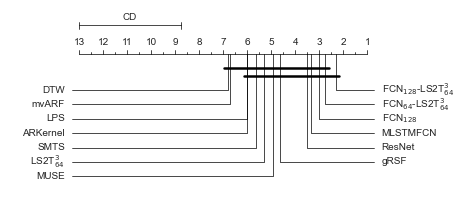

In [11]:
cd_diagram_fp = os.path.join(plots_dir, 'cd_diagram.pdf')

cd = Orange.evaluation.compute_CD(avg_rank, len(datasets), alpha='0.1', test='nemenyi')
Orange.evaluation.graph_ranks(avg_rank, cfg_names_formatted, cd=cd, width=6, textspace=1, reverse=True, filename=cd_diagram_fp)

#### Box plot

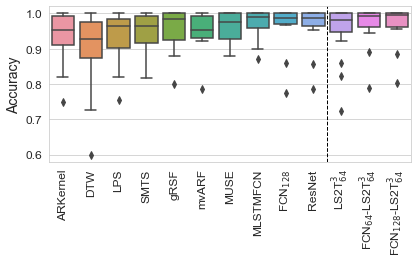

In [12]:
box_plot_fp = os.path.join(plots_dir, 'box_plot.pdf')

fig = plt.figure(figsize=(6, 3.75))
sns.boxplot(data=results_array)
plt.xticks(plt.xticks()[0], cfg_names_formatted, rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Accuracy', fontsize=14)
fig.patch.set_facecolor('white')
fig.tight_layout()
# fig.
plt.savefig(box_plot_fp, facecolor='white')

#### Bayesian signed-rank test

/scratch/toth/havok_env2/lib/python3.7/site-packages/baycomp/multiple.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


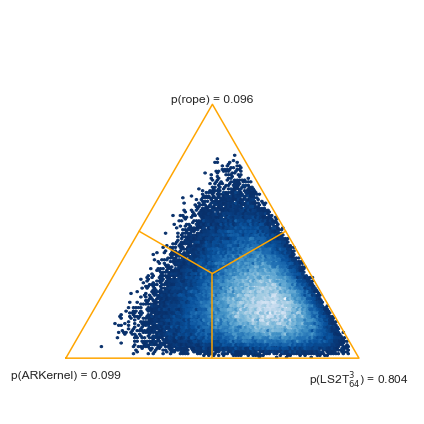

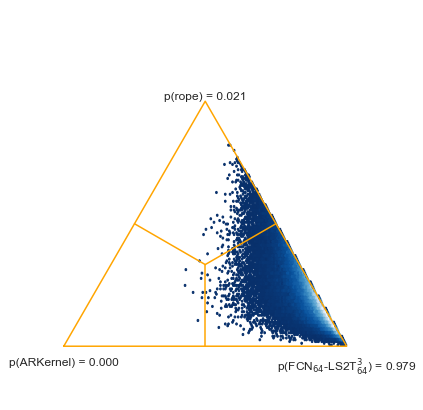

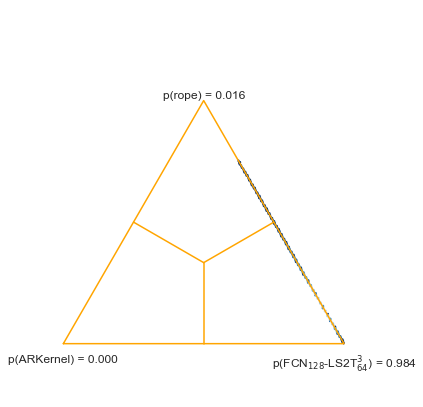

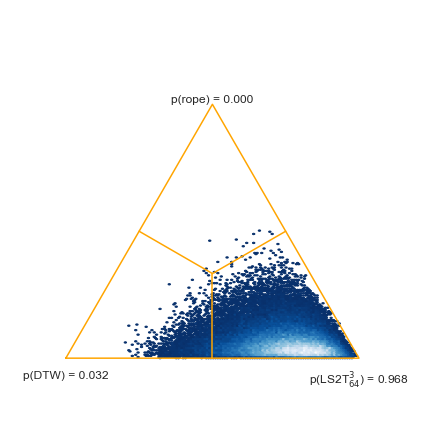

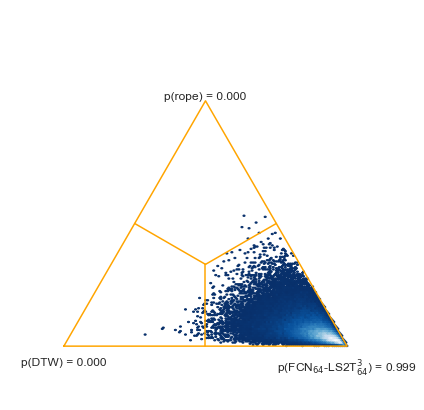

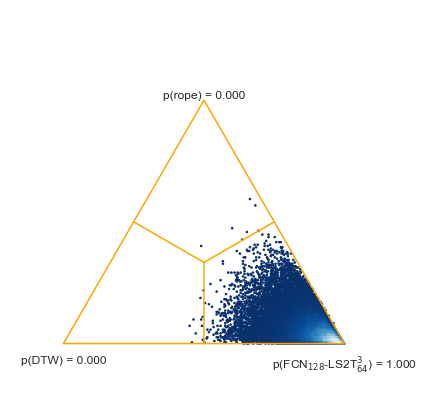

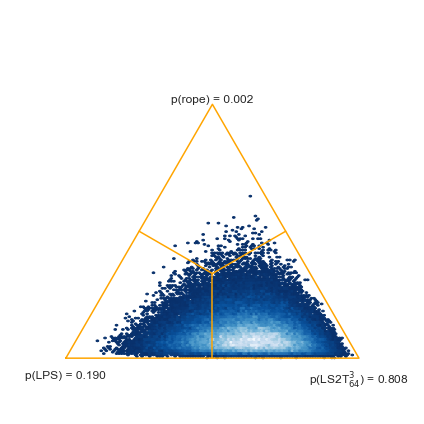

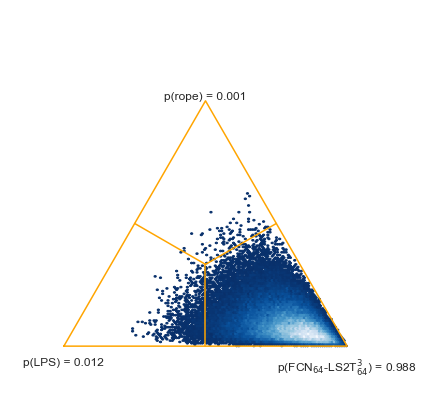

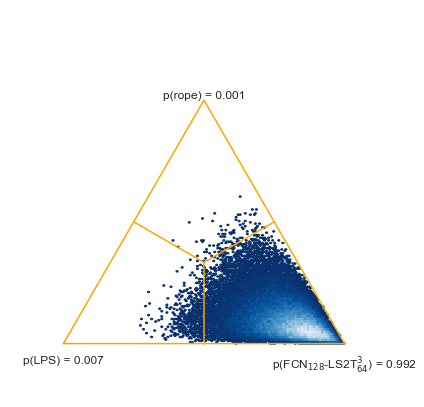

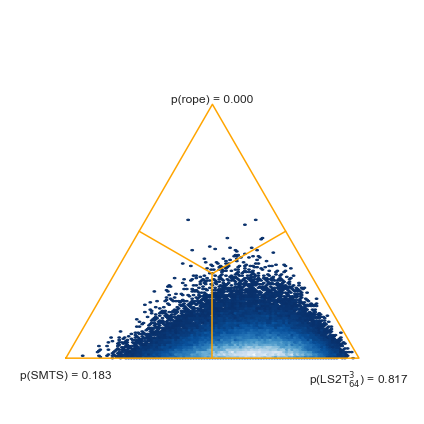

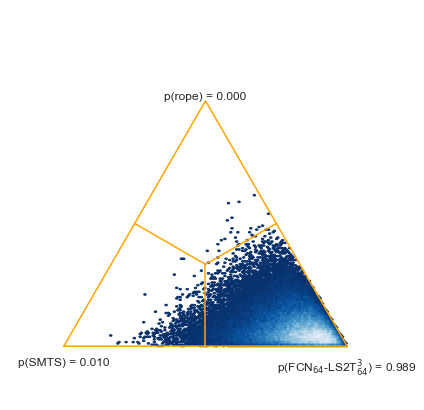

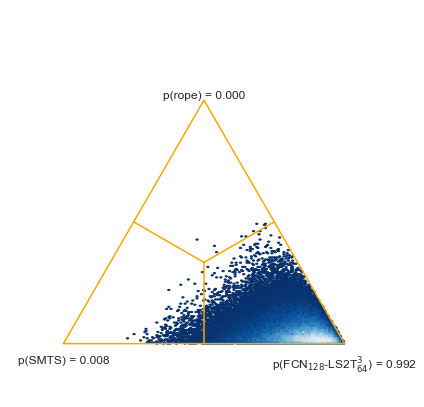

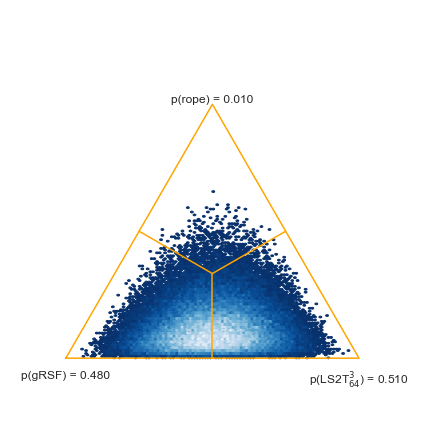

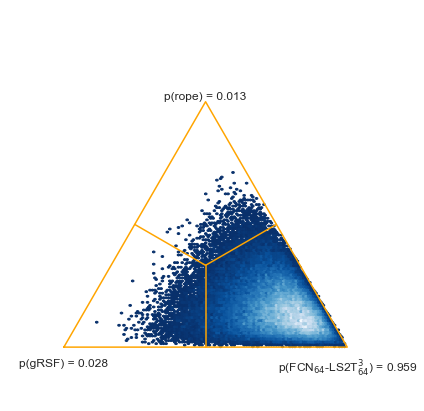

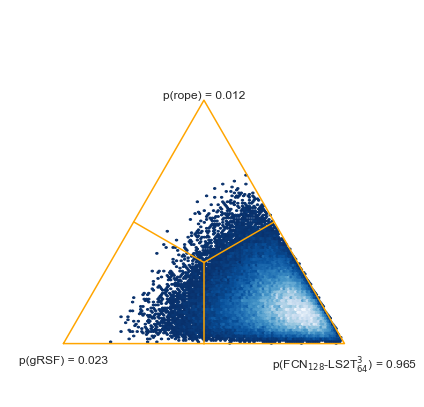

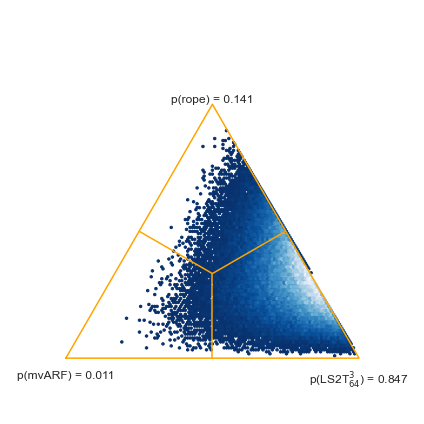

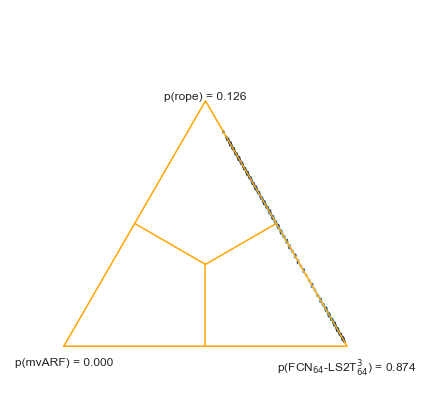

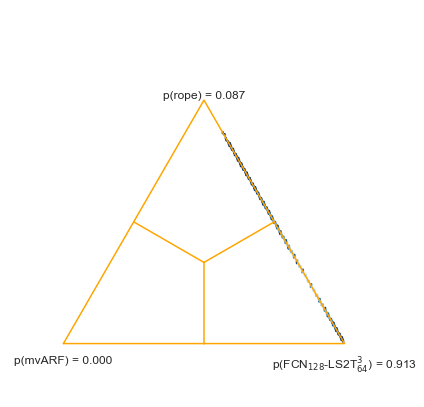

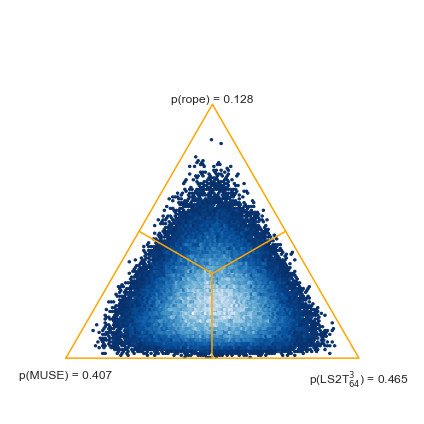

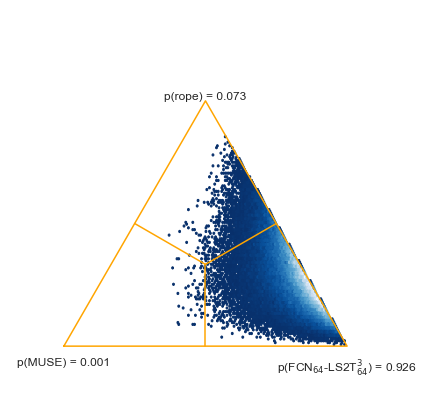

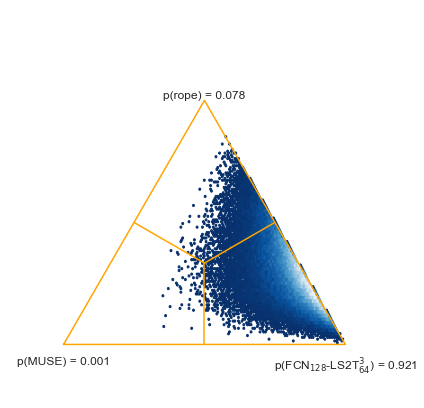

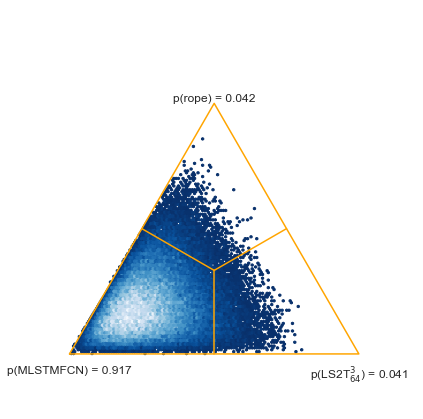

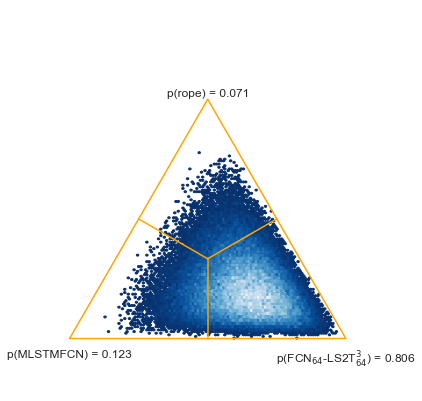

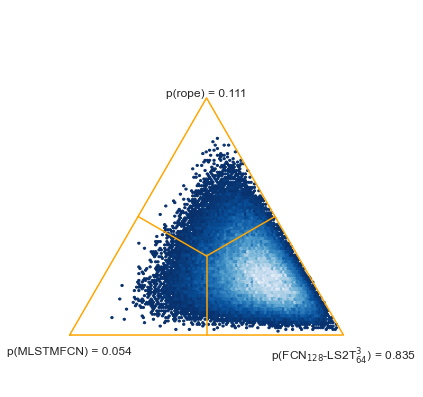

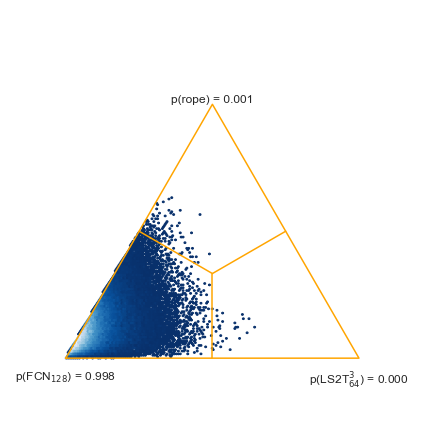

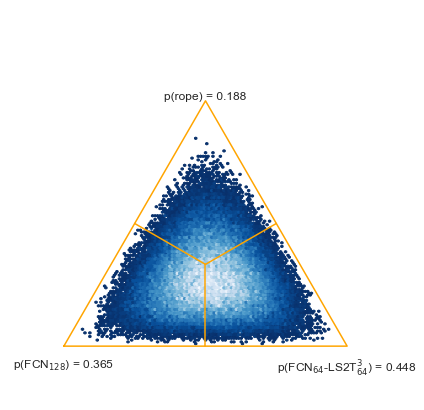

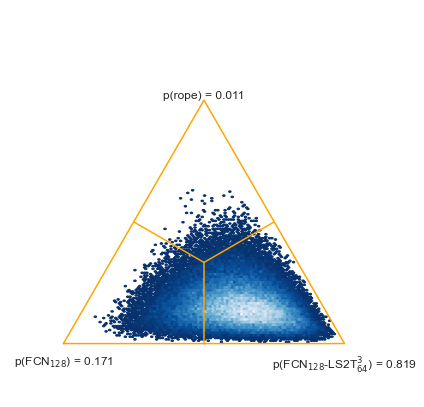

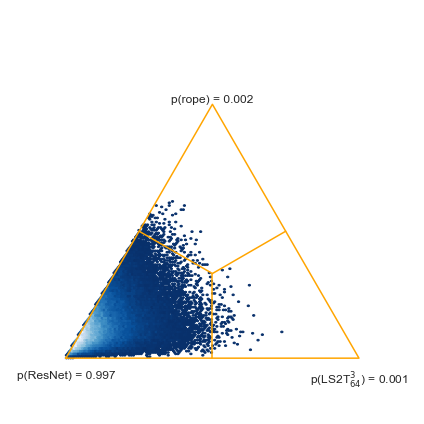

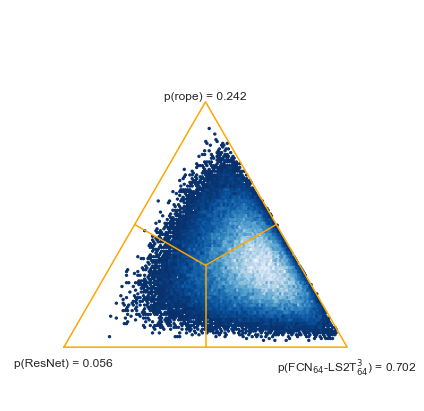

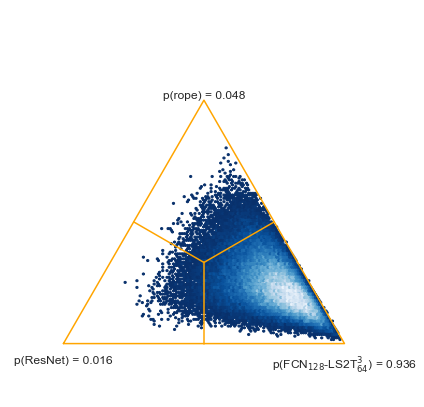

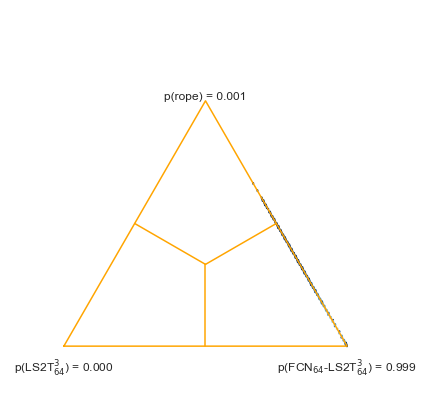

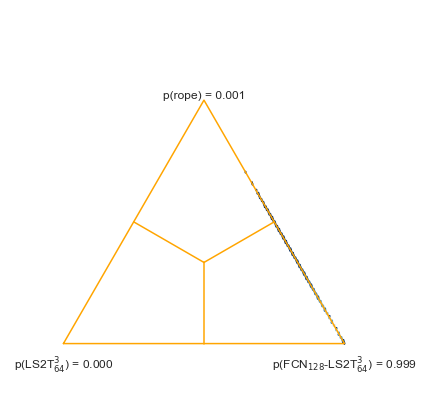

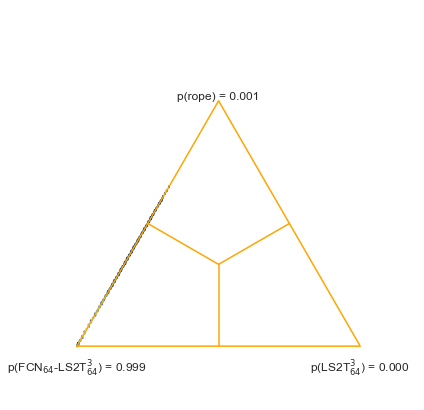

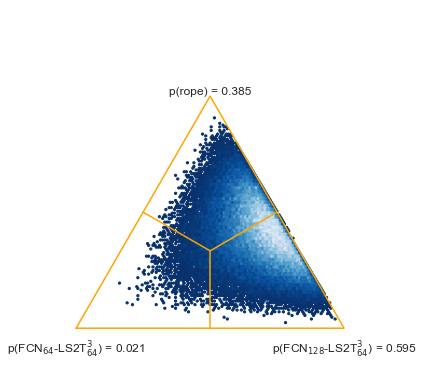

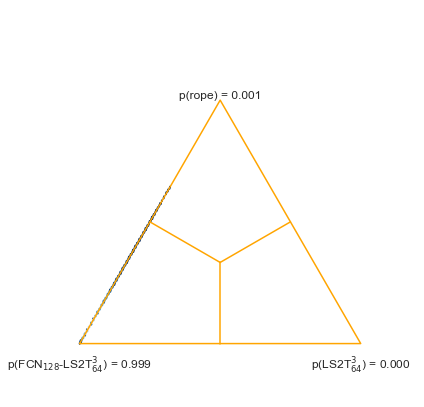

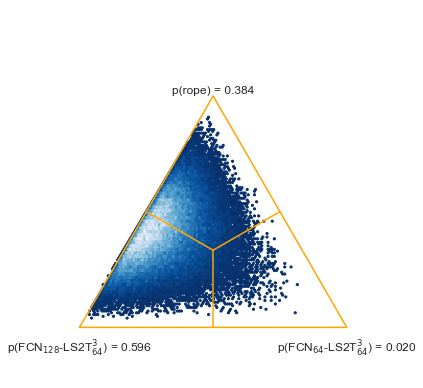

In [13]:
num_base = len(cfg_names_ext) + len(cfg_names_base)
num_main = len(cfg_names_main)
num_all = num_base + num_main
probs_array = np.zeros((num_all, 3 * num_main), dtype=float)
for i in range(num_all):
    for j in range(num_main):
        if num_all-num_main+j == i:
            continue
        test = baycomp.SignedRankTest(results_array[:, i], results_array[:, num_all-num_main+j], rope=1e-3, nsamples=100000)
        probs = test.probs()
        probs_array[i, 3*j:3*(j+1)] = probs
        fig = test.plot(names=(cfg_names_formatted[i], cfg_names_formatted[num_all-num_main+j]))
        fig.set_size_inches(6.0, 6.0)
        fig.patch.set_facecolor('white')
        fig.tight_layout()
        plt.tight_layout()
        fig_file = os.path.join(plots_dir, '{}_{}.png'.format(cfg_names[num_all-num_main+j], cfg_names[i]))
        plt.savefig(fig_file, facecolor='white')

In [14]:
cols = {}
cols[0] = 'LS2T64_>'
cols[1] = 'LS2T64_='
cols[2] = 'LS2T64_<'
cols[3] = 'FCN64LS2T64_>'
cols[4] = 'FCN64LS2T64_='
cols[5] = 'FCN64LS2T64_<'
cols[6] = 'FCN128LS2T64_>'
cols[7] = 'FCN128LS2T64_='
cols[8] = 'FCN128LS2T64_<'
df2 = pd.DataFrame(probs_array).rename(index={i:x for i, x in enumerate(cfg_names) if i < num_all}, columns=cols)
display(df2)

,LS2T64_>,LS2T64_=,LS2T64_<,FCN64LS2T64_>,FCN64LS2T64_=,FCN64LS2T64_<,FCN128LS2T64_>,FCN128LS2T64_=,FCN128LS2T64_<
ARKernel,0.099,0.096,0.804,0.000,0.021,0.979,0.000,0.016,0.984
DTW,0.032,0.000,0.968,0.000,0.000,0.999,0.000,0.000,1.000
LPS,0.190,0.002,0.808,0.012,0.001,0.988,0.007,0.001,0.992
SMTS,0.183,0.000,0.817,0.010,0.000,0.989,0.008,0.000,0.992
gRSF,0.480,0.010,0.510,0.028,0.013,0.959,0.023,0.012,0.965
mvARF,0.011,0.141,0.847,0.000,0.126,0.874,0.000,0.087,0.913
MUSE,0.407,0.128,0.465,0.001,0.073,0.926,0.001,0.078,0.921
MLSTMFCN,0.917,0.042,0.041,0.123,0.071,0.806,0.054,0.111,0.835
FCN128,0.998,0.001,0.000,0.365,0.188,0.448,0.171,0.011,0.819
ResNet,0.997,0.002,0.001,0.056,0.242,0.702,0.016,0.048,0.936
